In [1]:
import pandas as pd

df_chats = pd.read_csv('cleaned_data/chats_final.csv')
df_chats.head()

,id,client_id,question,answer,created_at,updated_at,bot_id,type,image_url,audio_url,has_image,has_audio,sentiment,sentiment_score,satisfaction
0,1,1,do you recommend traveling to beirut right now?,Traveling to Beirut can be a wonderful experie...,2024-08-19 14:44:14,2024-08-19 14:44:14,0,text,NaN,NaN,0,0,neutral,0.944790,0
1,2,1,when is the next flight going to italy?,The next flight from Beirut Airport to Italy i...,2024-08-19 14:45:19,2024-08-19 14:45:19,0,text,NaN,NaN,0,0,neutral,0.963298,0
2,3,1,"hello, tell me more about yourself",Hello! I'm here to assist you with your travel...,2024-08-19 14:52:22,2024-08-19 14:52:22,0,text,NaN,NaN,0,0,neutral,0.807940,0
3,4,1,hello tell me more about yourself,"Hello! I am your traveler assistant, here to h...",2024-08-19 14:53:10,2024-08-19 14:53:10,0,text,NaN,NaN,0,0,neutral,0.783783,0
4,5,1,who developed you,I was developed by Ibrahim Fleifel at Xpertbot...,2024-08-19 14:53:28,2024-08-19 14:53:28,0,text,NaN,NaN,0,0,neutral,0.804216,0


In [2]:
# clean question coluimn(lowercase all text, remove punctuation and special characters, remove stopwords, trim extra spaces)
import string
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def clean_text(text):
    if not isinstance(text, str):
        text = ''
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df_chats['cleaned_question'] = df_chats['question'].apply(clean_text)
df_chats.head()

,id,client_id,question,answer,created_at,updated_at,bot_id,type,image_url,audio_url,has_image,has_audio,sentiment,sentiment_score,satisfaction,cleaned_question
0,1,1,do you recommend traveling to beirut right now?,Traveling to Beirut can be a wonderful experie...,2024-08-19 14:44:14,2024-08-19 14:44:14,0,text,NaN,NaN,0,0,neutral,0.944790,0,recommend traveling beirut right
1,2,1,when is the next flight going to italy?,The next flight from Beirut Airport to Italy i...,2024-08-19 14:45:19,2024-08-19 14:45:19,0,text,NaN,NaN,0,0,neutral,0.963298,0,next flight going italy
2,3,1,"hello, tell me more about yourself",Hello! I'm here to assist you with your travel...,2024-08-19 14:52:22,2024-08-19 14:52:22,0,text,NaN,NaN,0,0,neutral,0.807940,0,hello tell
3,4,1,hello tell me more about yourself,"Hello! I am your traveler assistant, here to h...",2024-08-19 14:53:10,2024-08-19 14:53:10,0,text,NaN,NaN,0,0,neutral,0.783783,0,hello tell
4,5,1,who developed you,I was developed by Ibrahim Fleifel at Xpertbot...,2024-08-19 14:53:28,2024-08-19 14:53:28,0,text,NaN,NaN,0,0,neutral,0.804216,0,developed


In [3]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9, min_df=2, ngram_range=(1,2))
tfidf_matrix = vectorizer.fit_transform(df_chats['cleaned_question'])
tfidf_matrix.shape

(11021, 1000)

In [4]:
# clustering using KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_chats['cluster'] = kmeans.fit_predict(tfidf_matrix)
df_chats['cluster'].value_counts()

cluster
0    9913
1     545
2     447
4      93
3      23
Name: count, dtype: int64

In [5]:
# interpert clusters
import numpy as np
def get_top_terms_per_cluster(kmeans_model, vectorizer, n_terms=10):
    order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    cluster_terms = {}
    for i in range(kmeans_model.n_clusters):
        top_terms = [terms[ind] for ind in order_centroids[i, :n_terms]]
        cluster_terms[i] = top_terms
    return cluster_terms
top_terms = get_top_terms_per_cluster(kmeans, vectorizer)
for cluster, terms in top_terms.items():
    print(f"Cluster {cluster}: {', '.join(terms)}")

Cluster 0: image, give, lebanon, في, want, de, yes, من, analysis, هل
Cluster 1: hi, bob, understand, chatgpt, gpt, flight, work, know, loop, times
Cluster 2: hello, tell, difference, kifak, model, bonjour, internship, translate, solve, flights
Cluster 3: talk, way, love, deep, know, dont, bad, bob fleifel, arabic, gave
Cluster 4: thank, bob, thank bob, ok, much, lot, know, sure, okay, thats


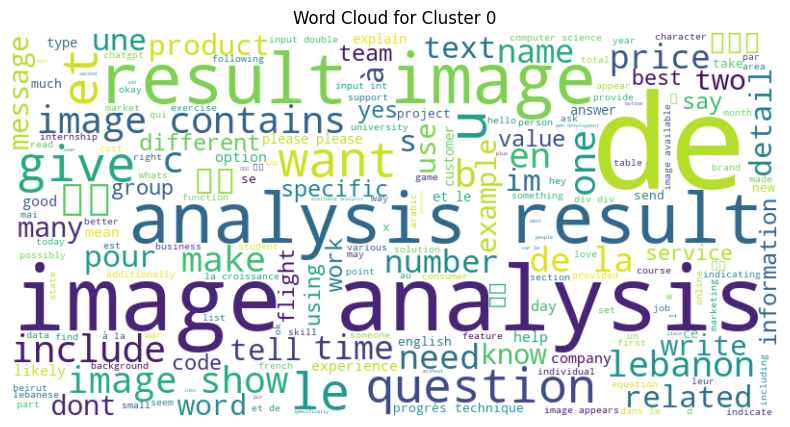

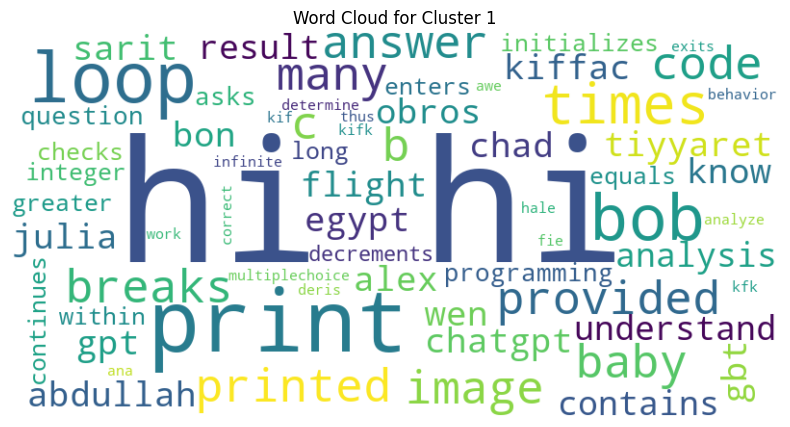

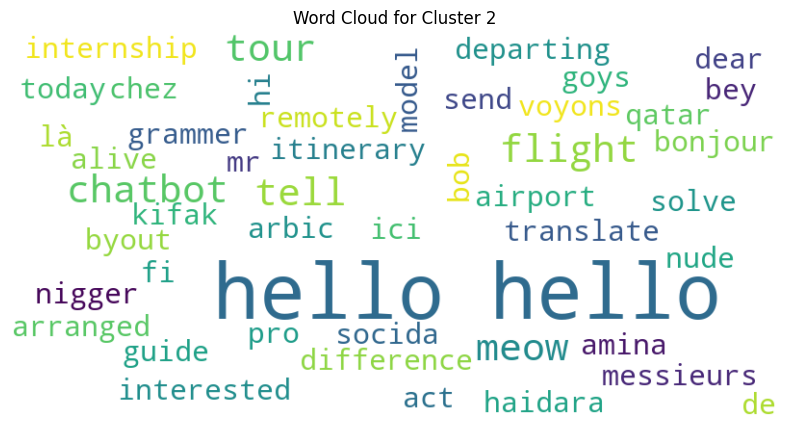

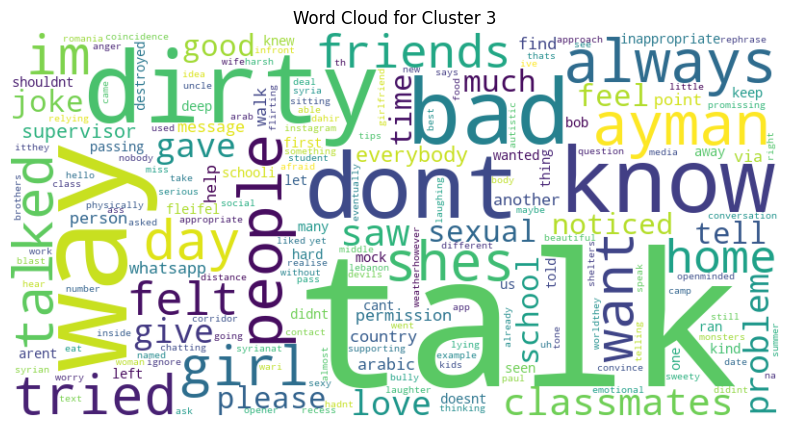

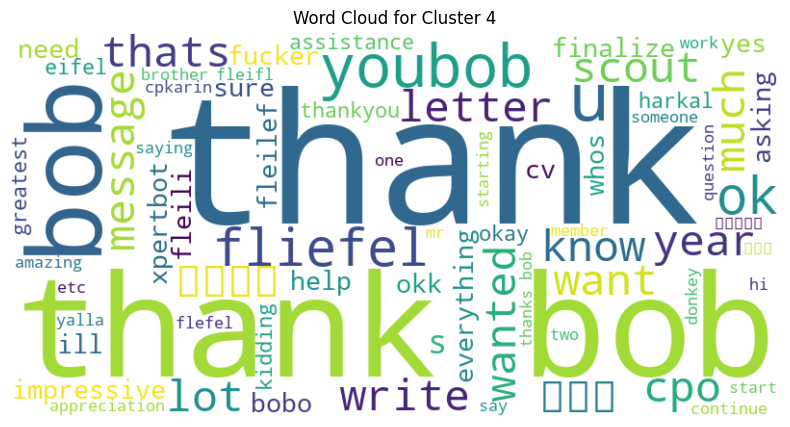

In [6]:
# visualize custers using word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
for cluster in range(kmeans.n_clusters):
    cluster_data = df_chats[df_chats['cluster'] == cluster]
    text = ' '.join(cluster_data['cleaned_question'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()

In [7]:
# save the cluster column to the original dataframe
df_chats.to_csv('cleaned_data/chats_final_with_clusters.csv', index=False)